In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [3]:
!ls

drive  sample_data


In [5]:
!cp drive/'My Drive'/GAF.zip /content

In [6]:
!unzip /content/GAF.zip

Streaming output truncated to the last 5000 lines.
  inflating: GAF/Aligned/Positive/pos_1324 (2).jpg  
  inflating: GAF/Aligned/Positive/pos_1324.jpg  
  inflating: GAF/Aligned/Positive/pos_1325 (2).jpg  
  inflating: GAF/Aligned/Positive/pos_1325.jpg  
  inflating: GAF/Aligned/Positive/pos_1326 (2).jpg  
  inflating: GAF/Aligned/Positive/pos_1326.jpg  
  inflating: GAF/Aligned/Positive/pos_1327 (2).jpg  
  inflating: GAF/Aligned/Positive/pos_1327.jpg  
  inflating: GAF/Aligned/Positive/pos_1328 (2).jpg  
  inflating: GAF/Aligned/Positive/pos_1328.jpg  
  inflating: GAF/Aligned/Positive/pos_1329 (2).jpg  
  inflating: GAF/Aligned/Positive/pos_1329.jpg  
  inflating: GAF/Aligned/Positive/pos_133 (2).jpg  
  inflating: GAF/Aligned/Positive/pos_133.jpg  
  inflating: GAF/Aligned/Positive/pos_1330 (2).jpg  
  inflating: GAF/Aligned/Positive/pos_1330.jpg  
  inflating: GAF/Aligned/Positive/pos_1331 (2).jpg  
  inflating: GAF/Aligned/Positive/pos_1331.jpg  
  inflating: GAF/Aligned/Positive

In [7]:
!cd GAF/ && ls

Aligned


In [8]:
!cd GAF/Aligned/ && ls

Negative  Neutral  Positive


In [9]:
# Ignore warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Data Manipulation libraries
import numpy as np
import pandas as pd

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib import style
 
# Matplotlib configuration
%matplotlib inline  
style.use('fivethirtyeight')

# Keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.layers import Dropout, Flatten, Activation, Reshape, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU
from keras.utils.data_utils import get_file

# Tensorflow
import tensorflow as tf

# Image manipulation libraries
import cv2                  
from PIL import Image

# Other libraries
import random
from tqdm import tqdm
import os
import itertools

# Set seed for random number generators
np.random.seed(42)
random.seed(42)
tf.set_random_seed(42)

Using TensorFlow backend.


In [10]:
# data
X = []
# labels
X_labels = []

# size of the image - 64x64
IMG_SIZE = 64

# assign variables for paths of each class
POSITIVE_DIR = 'GAF/Aligned/Positive/'
NEUTRAL_DIR = 'GAF/Aligned/Neutral/'
NEGATIVE_DIR = 'GAF/Aligned/Negative/'

In [12]:
def generate_data_from_images(emotion_type, directory):
  # tqdm used for progress bar
  # for each image in the specified directory
  for image in tqdm(os.listdir(directory)):
    filename = os.fsdecode(image)
    if filename.endswith(".jpg"): 
      # read the colored image
      image = cv2.imread(os.path.join(directory, image))
      # resize image to 64x64
      image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
      
      # append the image as a numpy array to X
      X.append(np.array(image))
      # append the label to Z
      X_labels.append(emotion_type)

In [13]:
generate_data_from_images('Positive', POSITIVE_DIR)

100%|██████████| 5724/5724 [01:03<00:00, 89.45it/s]


In [14]:
generate_data_from_images('Neutral', NEUTRAL_DIR)

100%|██████████| 4448/4448 [00:52<00:00, 84.08it/s]


In [15]:
generate_data_from_images('Negative', NEGATIVE_DIR)

100%|██████████| 3989/3989 [00:48<00:00, 81.69it/s]


In [16]:
len(X), len(X_labels)

(14161, 14161)

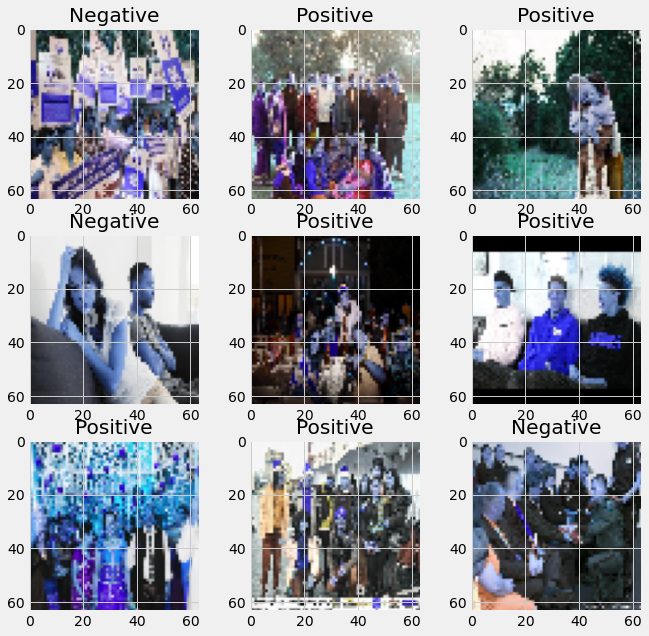

In [17]:

cols = 3
rows = 3
fig, axis = plt.subplots(rows, cols)
fig.set_size_inches(10, 10)
for i in range(rows):
  for j in range(cols):
    image_index = random.randint(0, len(X))
    axis[i, j].imshow(X[image_index])
    axis[i, j].set_title(X_labels[image_index])

In [19]:

# initialize the label encoder class
labelencoder = LabelEncoder()

# Convert the 3 classes "positive", "neutral" and "negative" into corresponding 
# numerical classes - 2, 1 and 0.
Y = labelencoder.fit_transform(X_labels)
# Check the classes applied by the Label Encoder
labelencoder_classes = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(labelencoder_classes)
# Apply one-hot encoding to convert the label encoded categorical data
# into multiple columns where each numerical class is replaced by 0 or 1
Y = to_categorical(Y,3)

# Convert X into a numpy array
X = np.array(X)
# Normalize all the pixel values for each image by diving by 255
X = X/255

{'Negative': 0, 'Neutral': 1, 'Positive': 2}


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [21]:
model = Sequential()

# Convolution layer
# (i) filters = 32 (the number of output filters i.e. number of feature maps 
# in the convolution)
# (ii) kernel_size = 5x5 (the height and width of the 2D convolution kernel 
# (also known as a feature detector))
# (iii) activation = relu
# (iv) input_shape = 64x64x3 because our input images are 64x64 and rgb
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
# Max pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())

# fully connected layer
model.add(Dense(512))

# Relu activation layer
model.add(Activation('relu'))

# Fully connected layer with softmax activation
model.add(Dense(3, activation = "softmax"))

model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [22]:
# Adapted from https://github.com/a514514772/Real-Time-Facial-Expression-Recognition-with-DeepLearning

model = Sequential()

# Zero-padding layer to add 1 pixel of padding to the height and width of the
# image
model.add(ZeroPadding2D((1,1), input_shape=(64,64,3)))
# Convolution layer
# (i) filters = 32 (the number of output filters i.e. number of feature maps 
# in the convolution)
# (ii) kernel_size = 3x3 (the height and width of the 2D convolution kernel 
# (also known as a feature detector))
# (iii) activation = relu
model.add(Conv2D(32, 3, 3, activation='relu'))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, 3, 3, activation='relu'))
# max pooling layer
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, 3, 3, activation='relu'))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, 3, 3, activation='relu'))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, 3, 3, activation='relu'))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())

# fully connected layer with ReLu activation
model.add(Dense(1024, activation='relu'))
# dropout
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# fully connected layer with softmax activation
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
model = Sequential()

# Block 1

# Convolution layer
# (i) filters = 64 (the number of output filters i.e. number of feature maps 
# in the convolution)
# (ii) kernel_size = 5x5 (the height and width of the 2D convolution kernel 
# (also known as a feature detector))
# (iii) border_mode = valid. This gives an output that is smaller than the 
# input because the convolution is only computed where the input and the filter 
# fully overlap.
# (iv) input_shape = 64x64x3 because our input images are 64x64 and rgb
model.add(Conv2D(64, 5, 5, border_mode='valid', input_shape=(64, 64, 3)))
# Parametric Rectified Linear Unit activation layer
model.add(PReLU(init='zero', weights=None))
# Zero-padding layer to add 2 pixels of padding to the height and width of the
# image
model.add(ZeroPadding2D(padding=(2, 2), dim_ordering='tf'))
# Max pooling layer
model.add(MaxPooling2D(pool_size=(5, 5),strides=(2, 2)))
# Zero-padding layer to add 1 pixel of padding to the height and width of the
# image
model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf'))

# Block 2
model.add(Conv2D(64, 3, 3))
model.add(PReLU(init='zero', weights=None))
model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf')) 

# Block 3
model.add(Conv2D(64, 3, 3))
model.add(PReLU(init='zero', weights=None))
model.add(AveragePooling2D(pool_size=(3, 3),strides=(2, 2)))
model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf'))

# Block 4
model.add(Conv2D(128, 3, 3))
model.add(PReLU(init='zero', weights=None))
model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf'))

# Block 5
model.add(Conv2D(128, 3, 3))
model.add(PReLU(init='zero', weights=None))
model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf'))
# Average pooling
model.add(AveragePooling2D(pool_size=(3, 3),strides=(2, 2)))

# Block 6
model.add(Flatten())

# Block 7
# fully connected layer
model.add(Dense(2048))
model.add(PReLU(init='zero', weights=None))
# dropout
model.add(Dropout(0.2))

# Block 8
model.add(Dense(1024))
model.add(PReLU(init='zero', weights=None))
model.add(Dropout(0.2))

# Block 8
model.add(Dense(512))
model.add(PReLU(init='zero', weights=None))
model.add(Dropout(0.2))

# Block 9
model.add(Dense(3))

# Block 10
# softmax activation function
model.add(Activation('softmax'))

# optimizer = Adadelta(lr=0.1, rho=0.95, epsilon=1e-08)

# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
# optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# optimizer = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

# after optimization
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

In [24]:
model = Sequential()

model.add(ZeroPadding2D((1,1), input_shape=(64, 64, 3)))

# Convolution layer
# (i) filters = 32 (the number of output filters i.e. number of feature maps 
# in the convolution)
# (ii) kernel_size = 3x3 (the height and width of the 2D convolution kernel 
# (also known as a feature detector))
# (iii) activation = ReLu
model.add(Conv2D(32, 3, 3, activation='relu'))
# Zero-padding layer to add 1 pixel of padding to the height and width of the
# image
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, 3, 3, activation='relu'))
# max pooling layer
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))


model.add(Flatten())

# fully connected layer with ReLu activation
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
# fully connected layer with softmax activation
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [25]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (11,11),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(3, activation = "softmax"))

model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [26]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-688df9pv
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-688df9pv
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp37-none-any.whl size=8312 sha256=e09901b164b6bbc3d27edd429118b5b21fec1aaa7b2c47283e0541c531b85690
  Stored in directory: /tmp/pip-ephem-wheel-cache-1xtitpgy/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [27]:
from keras.engine import Model
from keras_vggface.vggface import VGGFace

# initialize the VGGFace model
# exclude the top layer and set input shape to the shape of our images
vgg_model = VGGFace(include_top=False, input_shape=(64, 64, 3))
# get the output of the last layer
last_layer = vgg_model.get_layer('pool5').output
# flatten the last layer
x = Flatten(name='flatten')(last_layer)
# add a fully connected layer with ReLu activation
x = Dense(512, activation='relu', name='fc6')(x)
# add another fully connected layer with ReLu activation
x = Dense(512, activation='relu', name='fc7')(x)
# add a final fully connected layer with 3 neurons corresponding to our 3 classes and 
# a softmax activation since this is a multiclass classification problem
out = Dense(3, activation='softmax', name='fc8')(x)
# set the input and output for the model
model = Model(vgg_model.input, out)

# compile the model
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

58916864/58909280 [==============================] - 1s 0us/step


In [28]:
# set the paths for the weights file of VGG16
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

# define the model
def VGG16():

    img_input = Input(shape=(64, 64, 3))
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    x = GlobalAveragePooling2D()(x)

    top = Dense(256, activation='relu', name='fc')(x)
    top = Dropout(0.5)(top)
    out = Dense(3, activation='softmax', name='predictions')(top)

    model = Model(img_input, out, name='vgg16')

    weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                            WEIGHTS_PATH_NO_TOP,
                            cache_subdir='models')
    model.load_weights(weights_path, by_name=True)
    
    return model


lr = 0.0001

optimizer = Adagrad(lr, decay=1e-4)
model = VGG16()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

58892288/58889256 [==============================] - 1s 0us/step


In [29]:
batch_size=128
# batch_size = 64
# epochs=10

In [30]:
# define the data generator
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zoom_range = 0.1, 
        vertical_flip=False)

# fit on our training set
datagen.fit(X_train)

In [31]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [32]:
# get the position of the largest value for each label in y_train
# eg - argmax([0., 0., 1.]) = 2
y_ints = [y.argmax() for y in y_train]
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_ints), y_ints)

In [33]:
callbacks = []
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks.append(earlystop)

# history = model.fit(X_train,y_train, nb_epoch=400, \
#             batch_size=batch_size, \
#             validation_split=0.2, \
#             shuffle=True, verbose=1, \
#             callbacks=callbacks, class_weight=class_weights)

history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = 400, validation_data = (X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size, callbacks=callbacks, class_weight=class_weights)


Epoch 1/400
88/88 [==============================] - 27s 310ms/step - loss: 1.1189 - accuracy: 0.3654 - val_loss: 1.0874 - val_accuracy: 0.4123
Epoch 2/400
88/88 [==============================] - 16s 187ms/step - loss: 1.0908 - accuracy: 0.3947 - val_loss: 1.0841 - val_accuracy: 0.4123
Epoch 3/400
88/88 [==============================] - 16s 187ms/step - loss: 1.0903 - accuracy: 0.4017 - val_loss: 1.0857 - val_accuracy: 0.4123
Epoch 4/400
88/88 [==============================] - 17s 189ms/step - loss: 1.0887 - accuracy: 0.4015 - val_loss: 1.0819 - val_accuracy: 0.4123
Epoch 5/400
88/88 [==============================] - 16s 187ms/step - loss: 1.0879 - accuracy: 0.3997 - val_loss: 1.0803 - val_accuracy: 0.4123
Epoch 6/400
88/88 [==============================] - 17s 188ms/step - loss: 1.0860 - accuracy: 0.4038 - val_loss: 1.0786 - val_accuracy: 0.4123
Epoch 7/400
88/88 [==============================] - 16s 187ms/step - loss: 1.0834 - accuracy: 0.4004 - val_loss: 1.0719 - val_accuracy

In [34]:

# serialize model to JSON
model_json = model.to_json()
with open("vggface_adam.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("vggface_adam.h5")
print("Saved model to disk")

Saved model to disk


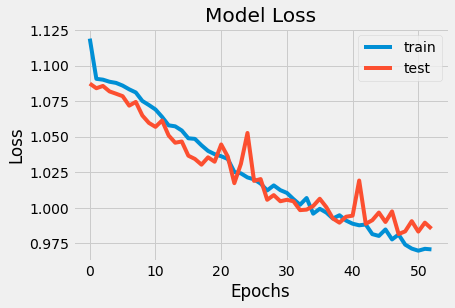

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

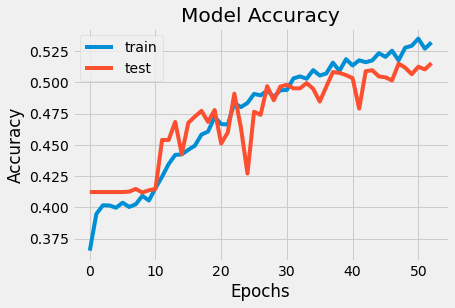

In [37]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [38]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

In [39]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Credit: https://github.com/scikit-learn/scikit-learn/blob/master/examples/model_selection/plot_confusion_matrix.py
    """
    np.set_printoptions(precision=2)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[372 109 264]
 [236 231 453]
 [204 107 857]]


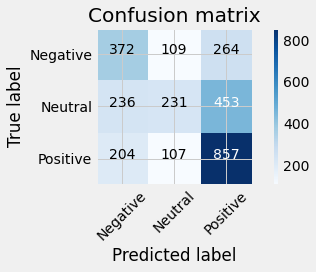

In [40]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure()
plot_confusion_matrix(cm, classes=labelencoder.classes_)
plt.show()

In [41]:
accuracy_score(y_true, y_pred_classes)

0.5153547476173668